# Input Parameters

In [1]:
# Range of N_HI to consider
NHI_min = 16.
NHI_max = 17.2

# Which data sets to use. First index should be the save file. Second index should be the actual key for the data.
# Warning: these will all be plotted together, so don't
data_identifiers = [
  
  # Full sample, both Wotta+16 and Lehner+13
  ['./final_metallicities.save', 'metall'],
  
  # Just the Wotta+16 sample
#   ['./final_metallicities.save', 'metcw'],
  
 # Just the Lehner+13 sample
#   ['./final_metallicities.save', 'metnl'],
  
]

# Shift edges very, very slightly, just to make sure everything's binned consistently.
# (Some data falls exactly on the edge of the bin)
shift_edges = 'left'
# shift_edges = 'right'
# shift_edges = None

# Choose the physical upper and lower bounds
lower_bounds = -3.
upper_bounds = 2.

# Save directory
save_dir = './plots'

# Imports and Other Setup

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


/Applications/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# Analysis imports

import copy
import math
import numpy as np
import os
import scipy as sp
import scipy.optimize
import scipy.stats
import scipy.special 
import scipy.signal
from scipy.io.idl import readsav
import sys

# Workaround for import issues...
sys.path.append('/Users/zhafen/FIRE_Research/Code/zhh_python/tools')

import general_plotting as gen_plot
from prob_dist_tools import basic_distributions
from prob_dist_tools import empirical_distribution_analysis_1d as emp_dist
import survival_analysis

In [4]:
# Lifelines imports

import lifelines
from lifelines import KaplanMeierFitter

In [5]:
# Plotting imports

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.use('PDF')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pu_colormaps as pu_cm
import matplotlib.transforms as transforms
import matplotlib.patheffects as path_effects

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
# Default changes to matplotlib

# Make the x and y ticks bigger
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2

In [7]:
# Function for saving plots

def save_fig(out_dir, save_file, fig=None, **save_args):                                                                                                                              
                                                                                                                                                                                     
  # Make sure the output directory exists                                                                                                                                            
  try:                                                                                                                                                                               
    os.makedirs(out_dir)                                                                                                                                                             
  except OSError as exc: # Python >2.5                                                                                                                                               
    if exc.errno == errno.EEXIST and os.path.isdir(out_dir):                                                                                                                         
      pass                                                                                                                                                                           
    else: raise                                                                                                                                                                      
                                                                                                                                                                                     
  default_save_args = {'dpi':300, 'bbox_inches':'tight'}                                                                                                                             
  used_save_args = zhh_dataio.mergeDict(save_args, default_save_args)                                                                                                                
                                                                                                                                                                                     
  # Save the figure.                                                                                                                                                                 
  if fig == None:                                                                                                                                                                    
    plt.savefig('%s/%s'%(out_dir, save_file), **used_save_args)                                                                                                                      
  else:                                                                                                                                                                              
    fig.savefig('%s/%s'%(out_dir, save_file), **used_save_args)                                                                                                                      
                                                                                                                                                                                     
  print 'File saved at %s/%s'%(out_dir, save_file)                                                                                                                                   
                                                                                                                                                                                     
  return 0   

# Data Retrieval

### Notes:
As a caution, I mixed up upper and lower limits throughout much of this notebook. I handle them correctly, I just call them differently -_- ...

Anyways, if in doubt, you can tell by the fact that the upper limits have many more data points.

## Data Analysis Setup

In [8]:
### Class for dealing with the observational data provided by Chris Wotta

class LOSObsData(object):

  def __init__(self, NHI_min=16.2, NHI_max=17.7):
    self.data_files = []
    self.data_names = []
    self.data_sets = []
    
    self.NHI_min = NHI_min
    self.NHI_max = NHI_max
    
  ########################################################################

  # Add a set of data

  def add_data(self, data_file, data_name):

    # For IDL files
    data_set = readsav(data_file)
    self.data_files.append(data_file)
    self.data_names.append(data_name)
    self.data_sets.append(data_set)

  ########################################################################

  # Get all data added together with limits applied

  def get_data(self, include_limits=True, return_errors=False):

    # What will be returned
    data_tot = np.array([])
    data_ep_tot = np.array([])
    data_em_tot = np.array([])

    # Iterate over the data
    for i in range(len(self.data_files)):

      # Get this particular data
      data_name = self.data_names[i]
      data_set = self.data_sets[i]
      data_vals = copy.deepcopy(np.array(data_set[data_name]))
      
      # Get the errors for this particular data
      data_ep = copy.deepcopy(np.array(data_set['ep_' + data_name]))
      data_em = copy.deepcopy(np.array(data_set['em_' + data_name]))

      # For keeping track of data we don't want to track
      invalid_inds = []

      # Remove data outside the N_HI range. Works for metallicity and column density, but doesn't work for everything.
      for j in range(len(data_vals)):
        if ((data_set['nhi' + data_name[3:]][j] < self.NHI_min) | (data_set['nhi' + data_name[3:]][j] > self.NHI_max)):
          invalid_inds.append(j)

      # Remove limits data if asked
      if not include_limits:
        for j in range(len(data_vals)):
          if ((data_ep[j] == 1.) | (data_em[j] == -1.)):
            invalid_inds.append(j)
      elif include_limits=='upper':
        for j in range(len(data_vals)):
          if (data_ep[j] == 1.):
            invalid_inds.append(j)
      elif include_limits=='lower':
        for j in range(len(data_vals)):
          if (data_em[j] == -1.):
            invalid_inds.append(j)
      elif include_limits=='upper only':
        for j in range(len(data_vals)):
          if (data_ep[j] != 1.):
            invalid_inds.append(j)
      elif include_limits=='lower only':
        for j in range(len(data_vals)):
          if (data_em[j] != -1.):
            invalid_inds.append(j)
            
      # Find duplicate invalid indices
      seen = set()
      seen_add = seen.add
      invalid_inds =  [x for x in invalid_inds if not (x in seen or seen_add(x))]

      # Actually remove the data
      data_vals = np.delete(data_vals, invalid_inds)
      data_ep = np.delete(data_ep, invalid_inds)
      data_em = np.delete(data_em, invalid_inds)

      # Add the data on
      data_tot = np.concatenate((data_tot, data_vals))
      data_ep_tot = np.concatenate((data_ep_tot, data_ep))
      data_em_tot = np.concatenate((data_em_tot, data_em))

    if return_errors:
      
      # Get the values of the mean, ignoring strange values
      mean_value_ep = data_ep_tot[np.where(data_ep_tot != 9.99e2)].mean()
      mean_value_em = data_em_tot[np.where(data_em_tot != 9.99e2)].mean()
      
      # Replace the large values in the data errorbars with the average values
      data_ep_tot = np.where(data_ep_tot != 9.99e2, data_ep_tot, mean_value_ep)
      data_em_tot = np.where(data_em_tot != 9.99e2, data_em_tot, mean_value_em)
      
      return [data_tot, data_ep_tot, data_em_tot]
    else:
      return data_tot

In [9]:
### Make the data object
obs_data = LOSObsData(NHI_min, NHI_max)

# Add the specified data
for data_identifier in data_identifiers:
  obs_data.add_data(data_identifier[0], data_identifier[1])


## Make a Basic Histogram

In [10]:
### Get the data out

# All data
all_data = obs_data.get_data()

# Without limits
base_data = obs_data.get_data(include_limits=False)

# With lower limits
lower_etc = obs_data.get_data(include_limits='lower')

# With upper limits
upper_etc = obs_data.get_data(include_limits='upper')

In [11]:
### Get histograms of the data

# Use same bins as Wotta+16
bin_width = .2
edges = np.arange(-2.6, .4+bin_width*2., bin_width)

# Shift edges very, very slightly, just to make sure everything's binned consistently
if shift_edges=='right':
  edges -= 0.0001
elif shift_edges=='left':
  edges += 0.0001

all_hist, edges = np.histogram(all_data, edges)
base_hist, edges = np.histogram(base_data, edges)
lower_etc_hist, edges = np.histogram(lower_etc, edges)
upper_etc_hist, edges = np.histogram(upper_etc, edges)

In [12]:
# Plotting Parameters

# What range to plot over?
# x_ll = -2.7
x_ll = -3.
x_ul = 2.

# Normalize?
normed = True

In [13]:
# Normalize the histograms
norm = base_hist.sum()*(edges[1] - edges[0])

all_hist = all_hist.astype(float)/norm
base_hist = base_hist.astype(float)/norm
lower_etc_hist = lower_etc_hist.astype(float)/norm
upper_etc_hist = upper_etc_hist.astype(float)/norm

Done.


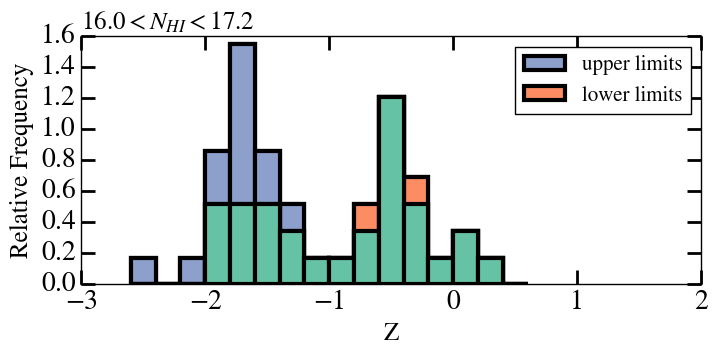

In [14]:
### Plot the data

fig = plt.figure(figsize=(8, 3.2))
ax = plt.gca()

# Plot all. If the other plotting was done properly this won't show up.
ax.bar(edges[:-1], all_hist, color='white', linewidth=3, width=bin_width)

# Plot upper limits
ax.bar(edges[:-1], upper_etc_hist, color='#8da0cb', linewidth=3, width=bin_width, \
      label='upper limits')

# Plot lower limits
ax.bar(edges[:-1], lower_etc_hist, color='#fc8d62', linewidth=3, width=bin_width, \
      label='lower limits')

# Plot base
ax.bar(edges[:-1], base_hist, color='#66c2a5', linewidth=3, width=bin_width)

# Tweak the plots
# Labels
ax.set_xlabel('Z', fontsize=18)
ax.set_ylabel('Relative Frequency', fontsize=18)
annotate_string = str(obs_data.NHI_min) + r'$<N_{HI}<$' + str(obs_data.NHI_max)
ax.annotate(annotate_string, (0,1.03), xycoords='axes fraction', fontsize=18)

# Set axis limits
ax.set_xlim([x_ll, x_ul])
# ax.set_ylim([0, 11])
# Legend
ax.legend(loc='upper right', prop={'size':15}, fontsize=20)

print 'Done.'

# Summation PDF Estimates

### Uniform Lower Limits

In [15]:
# Get the different types of data we want.

detections, det_eps, det_ems = obs_data.get_data(return_errors=True, include_limits=False)
lower_limits, ll_eps, ll_ems = obs_data.get_data(return_errors=True, include_limits='lower only')
upper_limits, ul_eps, ul_ems = obs_data.get_data(return_errors=True, include_limits='upper only')

In [16]:
# Make the detections into gaussian objects

x = np.linspace(-5, 4, 1024)
det_pdfs = []
for i, det in enumerate(detections):

  # Get the pdf
  det_prob = sp.stats.norm.pdf(x, det, np.sqrt(det_eps[i]))
  
  det_pdfs.append(det_prob)

In [17]:
# Make the lower limits into uniform distributions
ll_pdfs = []
for i, ll in enumerate(lower_limits):
  
  ll_pdf = sp.stats.uniform.pdf(x, lower_bounds, ll - lower_bounds)
  
  ll_pdfs.append(ll_pdf)

In [18]:
# Make the upper limits into uniform distributions
ul_pdfs = []
for i, ul in enumerate(upper_limits):
  
  ul_pdf = sp.stats.uniform.pdf(x, ul, upper_bounds - ul)
  
  ul_pdfs.append(ul_pdf)

In [19]:
# Function for adding a list of pdfs

def sum_pdf_list(pdf_list, x):
  
  # Sum
  pdf_list = np.array(pdf_list)
  tot_pdf = pdf_list.sum(0)
  
  # Normalize
  pdf_norm = np.trapz(tot_pdf, x)
  tot_pdf /= pdf_norm
  
  return tot_pdf

In [20]:
# Get the total summed pdfs

all_pdfs = det_pdfs + ll_pdfs + ul_pdfs
all_tot_pdf = sum_pdf_list(all_pdfs, x)

det_tot_pdf = sum_pdf_list(det_pdfs, x)
ll_tot_pdf = sum_pdf_list(ll_pdfs, x)
ul_tot_pdf = sum_pdf_list(ul_pdfs, x)


In [21]:
# Get the survival function for the total pdf

all_tot_cdf = []
for i, pdf_x in enumerate(all_tot_pdf):
  
  cdf_x = np.trapz(all_tot_pdf[:i+1], x[:i+1])
  
  all_tot_cdf.append(cdf_x)
  
all_tot_S = 1. - np.array(all_tot_cdf)

### Gaussian Limits

Test what happens if we use the limits and the average variance to estimate the limit locations as Gaussian pdfs.

In [22]:
# Get the average std deviation
used_sigma = det_eps.mean()

In [23]:
# Calculate the lower limit means (They're 2 sigma lower (really upper) limits.)
lower_mean_est = lower_limits - 2.*used_sigma

# Turn them into pdfs
ll_norm_pdfs = []
for i, ll_mean_est in enumerate(lower_mean_est):

  # Get the pdf
  ll_norm_pdf = sp.stats.norm.pdf(x, ll_mean_est, used_sigma)
  
  ll_norm_pdfs.append(ll_norm_pdf)

In [24]:
# Calculate the upper limit means (They're 2 sigma lower (really upper) limits.)
upper_mean_est = upper_limits + 2.*used_sigma

# Turn them into pdfs
ul_norm_pdfs = []
for i, ul_mean_est in enumerate(upper_mean_est):

  # Get the pdf
  ul_norm_pdf = sp.stats.norm.pdf(x, ul_mean_est, used_sigma)
  
  ul_norm_pdfs.append(ul_norm_pdf)

In [25]:
# Make the new pdfs

all_pdfs_alt = det_pdfs + ll_norm_pdfs + ul_norm_pdfs
all_pdfs_alt_tot = sum_pdf_list(all_pdfs_alt, x)

ll_tot_norm_pdf = sum_pdf_list(ll_norm_pdfs, x)
ul_tot_norm_pdf = sum_pdf_list(ul_norm_pdfs, x)

In [26]:
# Get the survival function for these

# Get the survival function for the total pdf

all_tot_cdf_alt = []
for i, pdf_x in enumerate(all_pdfs_alt_tot):
  
  cdf_x = np.trapz(all_pdfs_alt_tot[:i+1], x[:i+1])
  
  all_tot_cdf_alt.append(cdf_x)
  
all_tot_S_alt = 1. - np.array(all_tot_cdf_alt)

### Plotting of Estimates So Far

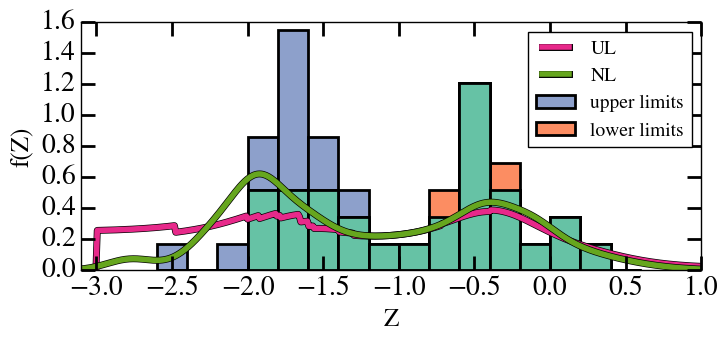

In [27]:
### Plot the data

fig = plt.figure(figsize=(8, 3.2))
ax = plt.gca()

# ax.plot(x, det_tot_pdf, linewidth=3)
# ax.plot(x, ll_tot_pdf, linewidth=3)
# ax.plot(x, ul_tot_pdf, linewidth=3)

# ax.plot(x, ll_tot_norm_pdf, linewidth=3)

# Plot upper limits
ax.bar(edges[:-1], upper_etc_hist, color='#8da0cb', linewidth=2, width=bin_width, \
      label='upper limits')

# Plot lower limits
ax.bar(edges[:-1], lower_etc_hist, color='#fc8d62', linewidth=2, width=bin_width, \
      label='lower limits')

# Plot base
ax.bar(edges[:-1], base_hist, color='#66c2a5', linewidth=2, width=bin_width)

ax.plot(x, all_tot_pdf, color='#e7298a', linewidth=4, label='UL', \
       path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])
ax.plot(x, all_pdfs_alt_tot, color='#66a61e', linewidth=4, label='NL', \
       path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Tweak the plots
# Labels
ax.set_xlabel('Z', fontsize=18)
ax.set_ylabel('f(Z)', fontsize=18)
# annotate_string = str(obs_data.NHI_min) + r'$<N_{HI}<$' + str(obs_data.NHI_max)
# ax.annotate(annotate_string, (0,1.03), xycoords='axes fraction', fontsize=18)

# Set axis limits
ax.set_xlim([-3.1, 1.])
# ax.set_ylim([0, 11])
# Legend
ax.legend(loc='upper right', prop={'size':14}, fontsize=20)


In [28]:
# Save this plot
save_file = 'summation_estimates.pdf'

gen_plot.saveFig(save_dir, save_file, fig)

File saved at ./plots/summation_estimates.pdf


0

# Survival Analysis PDF Estimate

### Test Example

First we'll construct the algorithm and test it, following an example from Klein&Moeschberger2003 (Survival analysis : techniques for censored and truncated data). The example is Example 5.1, and the algorithm is the Turnbull(1974) algorithm.

In [29]:
# Example Data

# Input times
t = np.array([0,] + range(10, 20, 1)).astype(float)

# Left censored data (# of data points with t_i as the upper limit)
c = np.array([0., 0., 0., 1., 2., 3., 2., 3., 1., 0.])

# Number of events at time t_i (actual detections with time t_i)
d = np.array([4., 12., 19., 24., 20., 13., 3., 1., 0., 4.])

# Right censored data (# of data points with t_i as the lower limit)
r = np.array([0., 0., 2., 15., 24., 18., 14., 6., 0., 0.])

In [30]:
# Calculate the number of individuals at risk at time t_i

Y = survival_analysis.calc_number_at_risk(d, r)

In [31]:
# Calculate the standard Product-Limit (Kaplan-Meier) Estimator as a first estimate, ignoring left censored data.

# Get the initial estimate
S_0 = [survival_analysis.kaplan_meier_estimator(t_, t, d, Y) for t_ in t]


In [32]:
# Update d for the first time
  
d_1 = survival_analysis.update_d(d, c, S_0)

# Make sure to also update Y
Y_1 = survival_analysis.calc_number_at_risk(d_1, r)

In [33]:
# Reupdate the Product-Limit Estimator

S_1 = [survival_analysis.kaplan_meier_estimator(t_, t, d_1, Y_1) for t_ in t]

In [34]:
# Here we print S_1, and as is apparent it comes out to have the same value as seen in Klein&Moeschberger2003.
# We know our functions are properly constructed

print S_1

[1.0, 0.97650781903971717, 0.90603127615886858, 0.79444341659752493, 0.65138932494597601, 0.51577909905516373, 0.39205114299169852, 0.34524847522316648, 0.3080678598401943, 0.3080678598401943, 0.0]


In [35]:
# Now we test our function to update S in a loop

s_est = survival_analysis.survival_function_estimator(t, c, d, r, keep_S_ks=True, keep_other_ks=True)

# Should be 0 everywhere
print s_est.S_ks[1] - S_1

Took 2 iterations to converge.
Final sum_of_square_diffs from previous iteration = 5.62e-08
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


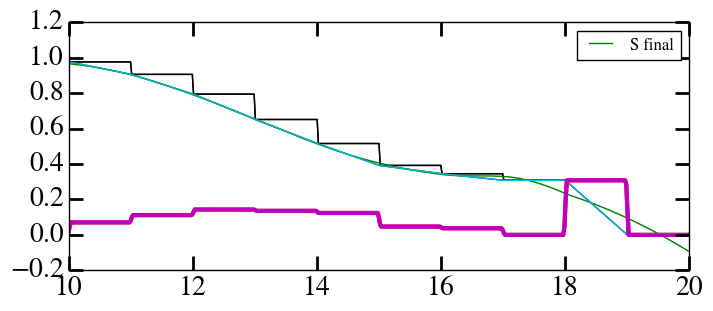

In [36]:
# Make a plot to illustrate the behavior

fig1 = plt.figure(figsize=(8, 3.2))
ax1 = plt.gca()

t_plot = np.linspace(0., 20., 1024)

# Plot all the S_ks
for i in range(len(s_est.d_ks)):
  
  S_plot = [survival_analysis.kaplan_meier_estimator(t_, t, s_est.d_ks[i], s_est.Y_ks[i]) for t_ in t_plot]
  ax1.plot(t_plot, S_plot, color='black')

# Get the interpolated final S
t_int = np.array([0,] + range(10, 20, 1) + [40,]).astype(float)
S_int = s_est.survival_fn_plot_array(t_int)
S_interp = sp.interpolate.interp1d(t_int, S_int)
S_int_plot = S_interp(t_plot)
ax1.plot(t_plot, S_int_plot)
S_savgol = sp.signal.savgol_filter(S_int_plot, 201, 2)
ax1.plot(t_plot, S_savgol, label='S final')

# Plot the Final pdf estimate
pdf = -np.gradient(S_int_plot, t_plot[1] - t_plot[0])
ax1.plot(t_plot, pdf, linewidth=3)
np.trapz(pdf, t_plot)

# Get the original interpolated S
S_int = [survival_analysis.kaplan_meier_estimator(t_, t, s_est.d_ks[0], s_est.Y_ks[0]) for t_ in t_int]
S_interp = sp.interpolate.interp1d(t_int, S_int)
S_int_plot = S_interp(t_plot)
ax1.plot(t_plot, S_int_plot)

# Plot the original pdf estimate
pdf = -np.gradient(S_int_plot, t_plot[1] - t_plot[0])
ax1.plot(t_plot, pdf, linewidth=3)
np.trapz(pdf, t_plot)

# Tidy up
ax1.set_xlim([10., 20.])
ax1.legend()


## Applying The Survival Function Estimator to the Wotta+16 Data

In [37]:
# First we will create functions to put the data in the right format (t, c, d, & r)

def format_data(data, c_d_or_r):
  '''Put the data into a format suitable to survival analysis
  
  data : data to format
  c_d_or_r : If the data is left censored (c, upper limits) = 'c'
             If the data are events (d, regular detections) = 'd'
             If the data is right censored (r, lower limits) = 'r'
  '''
  
  if c_d_or_r == 'c':
    cdr = [1., 0., 0.]
  elif c_d_or_r == 'd':
    cdr = [0., 1., 0.]
  elif c_d_or_r == 'r':
    cdr = [0., 0., 1.]
  
  # Make it into a format that can easily be combined
  data_f = np.array([data, np.ones(data.shape)*cdr[0], np.ones(data.shape)*cdr[1], \
                     np.ones(data.shape)*cdr[2]]).transpose()
  
  # Sort it
  data_f.sort(0)
  
  return data_f.tolist()

def consolidate_data(data):
  'Get rid of duplicate entries'
  
  # Sort the data and put into an array
  data = np.array(data)
  data = data[data[:,0].argsort()]
  
  # Get rid of duplicates
  data_f = []
  for i in range(len(data)):
    if (i>0) and (data[i][0] == data_f[-1][0]):
      data_f[-1][1:] += data[i][1:]
    else:
      data_f.append(data[i])
      
  return np.array(data_f)


### Get the Survival Functions

In [38]:
# Combine all the detections together

detections_f = format_data(detections, 'd')
lower_limits_f = format_data(lower_limits, 'c')
upper_limits_f = format_data(upper_limits, 'r')

combined_data = detections_f + lower_limits_f + upper_limits_f

In [39]:
# Consolidate the data

consolidated_data = consolidate_data(combined_data)

In [40]:
# Get out t, c, d, and r

t_w, c_w, d_w, r_w = consolidated_data.transpose()

In [41]:
# Estimate the survival function!

s_est = survival_analysis.survival_function_estimator(t_w, c_w, d_w, r_w, max_iterations=1e3, keep_S_ks=True, keep_other_ks=True)

Took 9 iterations to converge.
Final sum_of_square_diffs from previous iteration = 5.82e-07


In [42]:
# Repeat the process ignoring the lower limits to see the difference

combined_data_nll = detections_f + upper_limits_f
consolidated_data_nll = consolidate_data(combined_data_nll)

t_nll, c_nll, d_nll, r_nll = consolidated_data_nll.transpose()

s_est_nll = survival_analysis.survival_function_estimator(t_nll, c_nll, d_nll, r_nll, max_iterations=1e3, keep_S_ks=True, keep_other_ks=True)

Took 1 iterations to converge.
Final sum_of_square_diffs from previous iteration = 0


In [43]:
# Repeate the process, but using a the summation estimate survival function as ICs

# Interpolate the summation estimate to get the values out we wat
all_tot_S_int = sp.interpolate.interp1d(x, all_tot_S)
all_tot_S_0 = all_tot_S_int(t_w)

s_est_S_diff = survival_analysis.survival_function_estimator(t_w, c_w, d_w, r_w, max_iterations=1e3, keep_S_ks=True, \
                                           keep_other_ks=True, S_0=all_tot_S_0)

Took 7 iterations to converge.
Final sum_of_square_diffs from previous iteration = 8.43e-07


survival_analysis.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (S_0 == 'KaplanMeier'):
survival_analysis.py:197: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif k == 1 and S_0 != 'KaplanMeier':


(0.0, 1.0)

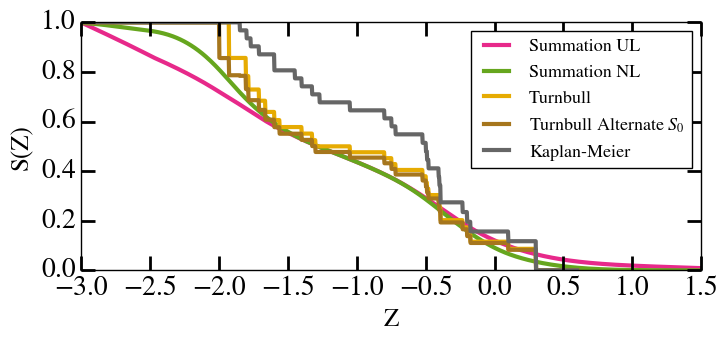

In [44]:
# Make a plot of the survival functions

fig2 = plt.figure(figsize=(8., 3.2))
ax2 = plt.gca()

# Data for plotting
t_plot = np.linspace(t_w.min()*2., t_w.max()*2., 2048)
S_plot_w = s_est.survival_fn_plot_array(t_plot)
S_plot_nll = s_est_nll.survival_fn_plot_array(t_plot)
S_plot_diff = s_est_S_diff.survival_fn_plot_array(t_plot)

# Plot of the summation estimate
ax2.plot(x, all_tot_S, linewidth=3, label='Summation UL', color='#e7298a')

# Plot of the summation estimate
ax2.plot(x, all_tot_S_alt, linewidth=3, label='Summation NL', color='#66a61e')

# Plot the full survival function
ax2.plot(t_plot, S_plot_w, linewidth=3, label='Turnbull', color='#e6ab02')

# Plot the full survival function with a different S_0
ax2.plot(t_plot, S_plot_diff, linewidth=3, label=r'Turnbull Alternate $S_0$', color='#a6761d')

# Plot the no-left-limit survival function
ax2.plot(t_plot, S_plot_nll, linewidth=3, label='Kaplan-Meier', color='#666666')

# Tweak plot
ax2.legend(prop={'size':13}, fontsize=20)
ax2.set_xlabel('Z', fontsize=18)
ax2.set_ylabel('S(Z)', fontsize=18)
ax2.set_xlim([-3., 1.5])
ax2.set_ylim([0., 1.])

In [45]:
# Save the plot
gen_plot.saveFig(save_dir, 'survival_functions.pdf', fig2)

File saved at ./plots/survival_functions.pdf


0

### Change Survival Functions to PDFs

In [46]:
# Get smoothed survival functions

# Change a physical width into a number of data points
window_width = .25
window_size = int(window_width/(t_plot[-1] - t_plot[0])*float(len(t_plot)))

# If even, make odd
if (window_size % 2)==0:
  window_size += 1
  
print window_size

# Total smoothing
S_plot_w_smoothed = s_est.smoothed_survival_fn(t_plot, window_size=window_size, polynomial_order=1)

93


(0.0, 1.0)

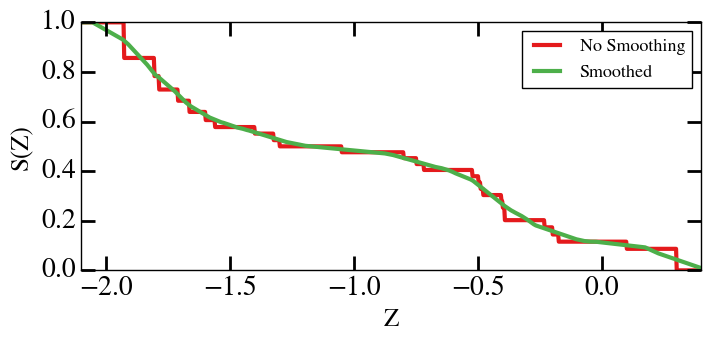

In [47]:
# Make a plot to show how the smoothing's done

fig3 = plt.figure(figsize=(8., 3.2))
ax3 = plt.gca()

# Plot the full survival function
ax3.plot(t_plot, S_plot_w, linewidth=3, label='No Smoothing', color='#e41a1c')

# Plot the full survival function
ax3.plot(t_plot, S_plot_w_smoothed, linewidth=3, label='Smoothed', color='#4daf4a')

# Tweak plot
ax3.legend(prop={'size':13}, fontsize=20)
ax3.set_xlabel('Z', fontsize=18)
ax3.set_ylabel('S(Z)', fontsize=18)
ax3.set_xlim([-2.1, 0.4])
ax3.set_ylim([0., 1.0])

In [48]:
# Save the plot

gen_plot.saveFig(save_dir, 'survival_fn_interpolation.pdf', fig3)

File saved at ./plots/survival_fn_interpolation.pdf


0

In [49]:
# Get the pdfs out

pdf_w = -np.gradient(S_plot_w, t_plot[1] - t_plot[0])
pdf_savgol = -np.gradient(S_plot_w_smoothed, t_plot[1] - t_plot[0])

(0.0, 2.0)

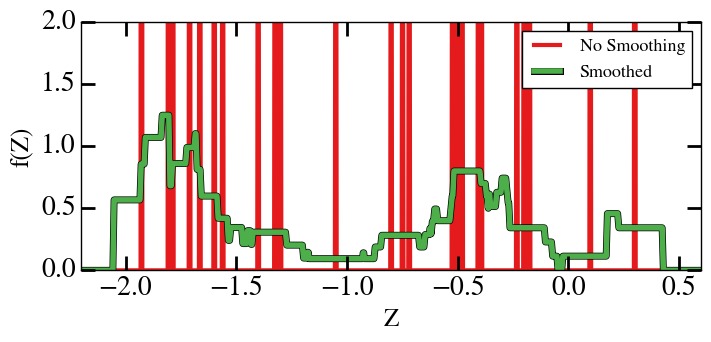

In [50]:
# Make a plot to show the pdf results of smoothing

fig4 = plt.figure(figsize=(8., 3.2))
ax4 = plt.gca()

# Not smoothed
ax4.plot(t_plot, pdf_w, linewidth=3., label='No Smoothing', color='#e41a1c')

# Fully smoothed
ax4.plot(t_plot, pdf_savgol, linewidth=4., label='Smoothed', color='#4daf4a',
        path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Tweak plot
ax4.legend(prop={'size':13}, fontsize=20)
ax4.set_xlabel('Z', fontsize=18)
ax4.set_ylabel('f(Z)', fontsize=18)
ax4.set_xlim([-2.2, 0.6])
ax4.set_ylim([0., 2.0])

In [51]:
# Save the figure

gen_plot.saveFig(save_dir, 'pdf_interpolation.pdf', fig4)

File saved at ./plots/pdf_interpolation.pdf


0

(0.0, 1.7)

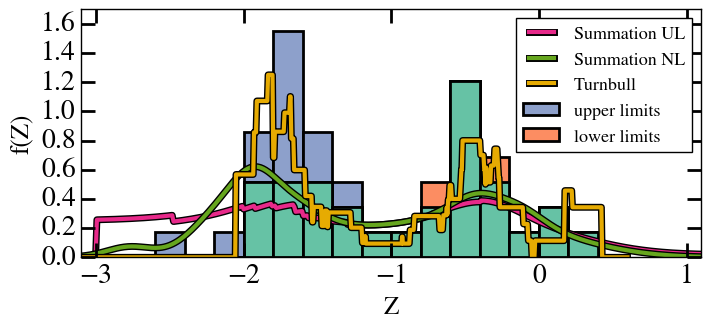

In [52]:
# Now make a plot of all the main pdfs we care about

fig5 = plt.figure(figsize=(8., 3.2))
ax5 = plt.gca()

# Plot upper limits
ax5.bar(edges[:-1], upper_etc_hist, color='#8da0cb', linewidth=2, width=bin_width, \
      label='upper limits')

# Plot lower limits
ax5.bar(edges[:-1], lower_etc_hist, color='#fc8d62', linewidth=2, width=bin_width, \
      label='lower limits')

# Plot base
ax5.bar(edges[:-1], base_hist, color='#66c2a5', linewidth=2, width=bin_width)

# Summation Estimate
ax5.plot(x, all_tot_pdf, linewidth=3., label='Summation UL', color='#e7298a',\
        path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Alternate Summation Estimate
ax5.plot(x, all_pdfs_alt_tot, linewidth=3., label='Summation NL', color='#66a61e',\
        path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Fully smoothed
ax5.plot(t_plot, pdf_savgol, linewidth=3., label='Turnbull', color='#e6ab02',\
        path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Fully smoothed alternative
# ax5.plot(t_plot, s_est_S_diff.estimate_pdf(t_plot), linewidth=3., label='Turnbull Alt', color='#a6761d',\
#         path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Tweak plot
ax5.legend(prop={'size':13}, loc='upper right', fontsize=20)
ax5.set_xlabel('Z', fontsize=18)
ax5.set_ylabel('f(Z)', fontsize=18)
ax5.set_xlim([-3.1, 1.1])
ax5.set_ylim([0., 1.7])

In [53]:
# Save the figure
gen_plot.saveFig(save_dir, 'all_pdfs.pdf', fig5)

File saved at ./plots/all_pdfs.pdf


0

In [54]:
# DEBUG

print t
actual_time_index = 8.
time = t[actual_time_index]

time_index = next(i for i, value in enumerate(t) if value > time) - 1 

print time_index

[  0.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.]
8


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Inverse Kaplan-Meier Estimation

In [55]:
# First we'll test if it works using the standard Kaplan-Meier estimator with just the detections
# and comparing it to 1 - the inverse, for the book example

t_plot_ex = np.linspace(0., 20., 1024)

# Standard version
Y_test = survival_analysis.calc_number_at_risk(d, np.zeros(d.shape))
S_std = np.array([survival_analysis.kaplan_meier_estimator(t_, t, d, Y_test) for t_ in t_plot_ex])

# Inverse version
W_test = survival_analysis.inverse_calc_number_at_risk(d, np.zeros(d.shape))
F_ikm = np.array([survival_analysis.inverse_kaplan_meier_estimator(t_, t, d, W_test) for t_ in t_plot_ex])
S_ikm = 1. - F_ikm

# Compare the two. Should be zero, or close to zero, everywhere.
print np.abs((S_std - S_ikm)).max()

1.66533453694e-16


In [56]:
# Now calculate the inverse for our data set, counting the two lower limits as data points

W_w = survival_analysis.inverse_calc_number_at_risk(d_w, c_w)
F_ikm_w = np.array([survival_analysis.inverse_kaplan_meier_estimator(t_, t_w, d_w, W_w) for t_ in t_plot])
S_ikm = 1. - F_ikm_w

In [57]:
# Convert the Inverse Kaplan-Meier estimate into a pdf.

# Change a physical width into a number of data points
window_width = .25
window_size = int(window_width/(t_plot[-1] - t_plot[0])*float(len(t_plot)))

# If even, make odd
if (window_size % 2)==0:
  window_size += 1
  
print window_size

# Smooth it
S_smoothed_ikm = sp.signal.savgol_filter(S_ikm, window_size, 1)

# Convert to a pdf
pdf_ikm = -np.gradient(S_smoothed_ikm, t_plot[1] - t_plot[0])

93


(0.0, 1.0)

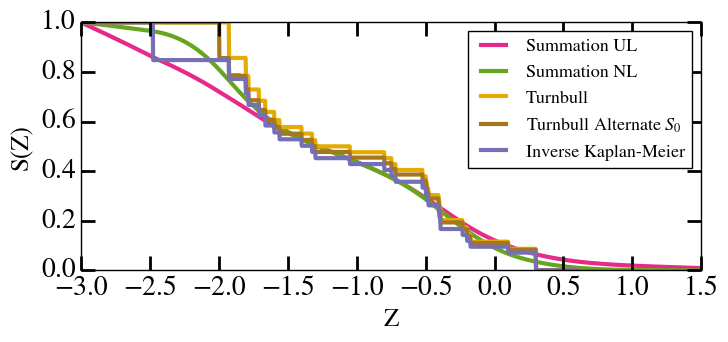

In [58]:
# Plot the survival function alongside the other survival functions

fig6 = plt.figure(figsize=(8., 3.2))
ax6 = plt.gca()

# Plot of the summation estimate
ax6.plot(x, all_tot_S, linewidth=3, label='Summation UL', color='#e7298a')

# # Plot of the summation estimate
ax6.plot(x, all_tot_S_alt, linewidth=3, label='Summation NL', color='#66a61e')

# Plot the full survival function
ax6.plot(t_plot, S_plot_w, linewidth=3, label='Turnbull', color='#e6ab02')

# Plot the full survival function with a different S_0
ax6.plot(t_plot, S_plot_diff, linewidth=3, label=r'Turnbull Alternate $S_0$', color='#a6761d')

# Plot the no-left-limit survival function
# ax6.plot(t_plot, S_plot_nll, linewidth=3, label='Kaplan-Meier', color='#666666')

# Plot the full survival function using the Inverse Kaplan-Meier estimate
ax6.plot(t_plot, S_ikm, linewidth=3, label=r'Inverse Kaplan-Meier', color='#7570b3')

# Plot the full survival function using the Inverse Kaplan-Meier estimate
# ax6.plot(t_plot, S_smoothed_ikm, linewidth=3, label=r'Smooth IKM', color='#7570b3')

# Tweak plot
ax6.legend(prop={'size':13}, fontsize=20)
ax6.set_xlabel('Z', fontsize=18)
ax6.set_ylabel('S(Z)', fontsize=18)
ax6.set_xlim([-3., 1.5])
ax6.set_ylim([0., 1.])

In [59]:
# Save the plot

gen_plot.saveFig(save_dir, 'survival_fn_ikm.pdf', fig6)

File saved at ./plots/survival_fn_ikm.pdf


0

(0.0, 1.7)

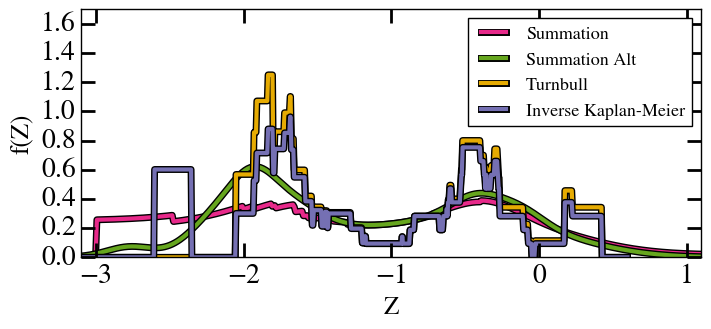

In [60]:
# Compare the CDFs

fig6 = plt.figure(figsize=(8., 3.2))
ax6 = plt.gca()

# Summation Estimate
ax6.plot(x, all_tot_pdf, linewidth=3., label='Summation', color='#e7298a',\
        path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Alternate Summation Estimate
ax6.plot(x, all_pdfs_alt_tot, linewidth=3., label='Summation Alt', color='#66a61e',\
        path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Fully smoothed
ax6.plot(t_plot, pdf_savgol, linewidth=3., label='Turnbull', color='#e6ab02',\
        path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Inverse ikm estimate
ax6.plot(t_plot, pdf_ikm, linewidth=3., label='Inverse Kaplan-Meier', color='#7570b3',\
        path_effects=[path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()])

# Tweak plot
ax6.legend(prop={'size':13}, loc='upper right', fontsize=20)
ax6.set_xlabel('Z', fontsize=18)
ax6.set_ylabel('f(Z)', fontsize=18)
ax6.set_xlim([-3.1, 1.1])
ax6.set_ylim([0., 1.7])

### Additional Analysis

In [61]:
# Show that the integrals are 1 regardless of the pdf

print np.trapz(all_tot_pdf, x)

print np.trapz(all_pdfs_alt_tot, x)

print np.trapz(pdf_ikm, t_plot)

print np.trapz(pdf_savgol, t_plot)


1.0
1.0
1.0
1.0
